In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip -P ./dataset

In [2]:
# !unzip ./dataset/ml-100k.zip -d ./dataset

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds

In [4]:
# PATH
data_path = "./dataset/ml-100k/u.data"
movies_path = "./dataset/ml-100k/u.item"

# Loading users
with open(data_path, "r") as f:
    data = f.readlines()

u_ids = []
m_ids = []
ratings = []

for line in data:
    user_id, movie_id, rating, _ = map(int, line.split("\t"))
    u_ids.append(user_id)
    m_ids.append(movie_id)
    ratings.append(rating)

In [5]:
# Loading movies
movie_names = {}
with open(movies_path, "r", encoding="latin-1") as f:
    for line in f:
        parts = line.split("|")
        movie_id = int(parts[0])
        movie_name = parts[1]
        movie_names[movie_id] = movie_name

num_u = max(u_ids)
num_m = max(m_ids)

rating_m = np.zeros((num_u, num_m), dtype=np.float32)
for user_id, movie_id, rating in zip(u_ids, m_ids, ratings):
    rating_m[user_id - 1, movie_id - 1] = rating

# Normalize
user_avg = np.true_divide(rating_m.sum(axis=1), (rating_m != 0).sum(axis=1))
user_avg = np.nan_to_num(user_avg)
rating_m_norm = rating_m - user_avg[:, np.newaxis]
rating_m_norm[rating_m == 0] = 0

# SVD
U, sigma, Vt = svds(rating_m_norm, k=50)
sigma = np.diag(sigma)

pred_ratings = np.dot(np.dot(U, sigma), Vt) + user_avg[:, np.newaxis]

# Evaluation Metrics
def calculate_mae(predicted, actual):
    mask = actual > 0
    return np.mean(np.abs(predicted[mask] - actual[mask]))

def calculate_rmse(predicted, actual):
    mask = actual > 0
    return np.sqrt(np.mean((predicted[mask] - actual[mask]) ** 2))

user_mae = []
user_rmse = []
num_ratings = []

for user_id in range(1, num_u + 1):
    user_index = user_id - 1
    actual_ratings = rating_m[user_index]
    pred_ratings_user = pred_ratings[user_index]
    mae = calculate_mae(pred_ratings_user, actual_ratings)
    rmse = calculate_rmse(pred_ratings_user, actual_ratings)
    count = np.sum(actual_ratings > 0)
    user_mae.append(mae)
    user_rmse.append(rmse)
    num_ratings.append(count)

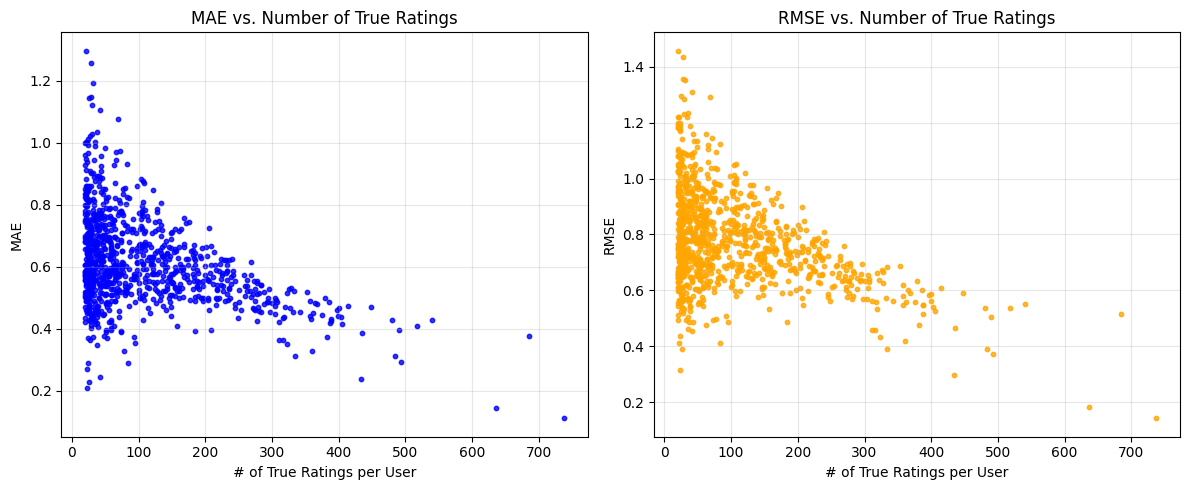

In [6]:
# Plotting
plt.figure(figsize=(12, 5))

# MAE Plot
plt.subplot(1, 2, 1)
plt.xlabel("# of True Ratings per User")
plt.ylabel("MAE")
plt.scatter(num_ratings, user_mae, color="blue", alpha=0.8, s=10)
plt.title("MAE vs. Number of True Ratings")
plt.grid(alpha=0.3)

# RMSE Plot
plt.subplot(1, 2, 2)
plt.xlabel("# of True Ratings per User")
plt.ylabel("RMSE")
plt.scatter(num_ratings, user_rmse, color="orange", alpha=0.8, s=10)
plt.title("RMSE vs. Number of True Ratings")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()